# Injection Molding Analysis with Causal Models and DoubleML
This notebook demonstrates the use of probabilistic and structural causal models along with DoubleML for predicting part weight in an injection molding process. We load the dataset, prepare the data, set up our models, generate predictions, and finally visualize the results and performance metrics.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from functools import partial
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from dowhy.gcm import (
    ProbabilisticCausalModel,
    StructuralCausalModel,
    fit,
    interventional_samples
)
from dowhy.gcm.stochastic_models import EmpiricalDistribution
from dowhy.gcm.ml.regression import SklearnRegressionModel
from dowhy.gcm import AdditiveNoiseModel
from doubleml import DoubleMLData

import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Thesis colour palette (HEX)
fapsgreen_hex     = "#97C139"
fapsblue_hex      = "#296193"
fapsdarkgray_hex  = "#5F5F5F"

# Set the random seed for reproducibility
np.random.seed(42)

## 2. Data Loading and Preparation

In [2]:
def load_data(filepath, material_filter='PP'):
    select_cols = [
        'DXP_HoldingPressure1',
        'E77_BarrelTemperatureZone6',
        'E77_TransferStroke',
        'E77_CushionVolume',
        'E77_DosingTime',
        'DXP_AreaCavityPressure',
        'SCA_PartWeight',
        'E77_CavityPressureMaximum',
        'MET_MachineCycleID',
        'MET_MaterialName',
        'MET_ExperimentNumber'
    ]
    df = pd.read_csv(filepath)
    df = df[select_cols]
    if material_filter:
        df = df[df['MET_MaterialName'] == material_filter]
    df.drop(columns=['MET_MaterialName', 'MET_MachineCycleID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Update the file path as needed
filepath = './dataset.csv'
data = load_data(filepath, material_filter='PP')
data

,DXP_HoldingPressure1,E77_BarrelTemperatureZone6,E77_TransferStroke,E77_CushionVolume,E77_DosingTime,DXP_AreaCavityPressure,SCA_PartWeight,E77_CavityPressureMaximum,MET_ExperimentNumber
0,150.4,220.0,24.3045,10.29,10810.0,1840.3,97.56,89.0,A01-H
1,150.4,220.0,24.3045,10.23,10810.0,1838.2,97.57,89.0,A01-H
2,150.4,220.0,24.3045,10.38,10880.0,1783.4,97.52,85.0,A01-H
3,150.4,220.0,24.3045,10.19,10970.0,1825.9,97.57,89.0,A01-H
4,150.4,220.0,24.3045,10.38,10850.0,1775.2,97.50,85.0,A01-H
...,...,...,...,...,...,...,...,...,...
298,150.0,262.0,27.8410,7.22,10890.0,3275.0,97.62,98.0,A28-H
299,150.0,262.0,27.8410,7.23,10990.0,3234.9,97.57,98.0,A28-H
300,149.9,262.0,27.8410,7.40,10970.0,3247.9,97.66,99.0,A28-H
301,150.0,262.0,27.8410,7.40,11000.0,3285.7,97.69,99.0,A28-H


In [3]:
def split_data(df, test_size=0.2, random_state=11):
    target = df["SCA_PartWeight"]
    features = df.drop(columns=["SCA_PartWeight"])
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=test_size, 
        random_state=random_state
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data, test_size=0.2, random_state=11)
print(f"\nTraining samples: {X_train.shape[0]}  Testing samples: {X_test.shape[0]}")    


Training samples: 242  Testing samples: 61


## 3. Setup for Causal Models (PCM/SCM) and DoubleML

In [12]:
graph_def_G = """
digraph {
    E77_DosingTime -> SCA_PartWeight;
    E77_CushionVolume -> SCA_PartWeight;
    DXP_AreaCavityPressure -> SCA_PartWeight;
    E77_CavityPressureMaximum -> SCA_PartWeight;
    DXP_HoldingPressure1 -> E77_DosingTime;
    E77_BarrelTemperatureZone6 -> E77_DosingTime;
    DXP_HoldingPressure1 -> E77_CushionVolume;
    E77_BarrelTemperatureZone6 -> E77_CushionVolume;
    E77_TransferStroke -> E77_CushionVolume;
    DXP_HoldingPressure1 -> E77_CavityPressureMaximum;
    E77_BarrelTemperatureZone6 -> E77_CavityPressureMaximum;
    DXP_HoldingPressure1 -> DXP_AreaCavityPressure;
    E77_BarrelTemperatureZone6 -> DXP_AreaCavityPressure;
}
"""

def setup_gcm(graph_def):
    (graph,) = pydot.graph_from_dot_data(graph_def)
    G = nx.DiGraph(nx.drawing.nx_pydot.from_pydot(graph))
    
    exogenous_vars = ['DXP_HoldingPressure1', 'E77_BarrelTemperatureZone6', 'E77_TransferStroke']
    causal_mechanisms = {
        v: EmpiricalDistribution() if v in exogenous_vars 
           else AdditiveNoiseModel(SklearnRegressionModel(LinearRegression()))
        for v in G.nodes()
    }
    
    pcm_ = ProbabilisticCausalModel(G)
    scm_ = StructuralCausalModel(G)
    
    for node, mech in causal_mechanisms.items():
        pcm_.set_causal_mechanism(node, mech)
        scm_.set_causal_mechanism(node, mech)
    
    return G, pcm_, scm_

G, pcm, scm = setup_gcm(graph_def_G)

In [13]:
def setup_doubleml(X_train, y_train, covariates, treatment_vars, n_splits=5):
    # Combine data into a single DataFrame for DoubleML
    train_data = X_train.copy()
    train_data['SCA_PartWeight'] = y_train
    
    # Initialize DoubleMLData
    dml_data = DoubleMLData(
        data=train_data,
        y_col='SCA_PartWeight',
        d_cols=treatment_vars,
        x_cols=covariates
    )
    
    # Initialize Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=11)
    
    # Prepare data for cross-fitting
    X_combined = train_data[covariates + treatment_vars]
    y_combined = train_data['SCA_PartWeight']
    
    # Initialize arrays to store cross-fitted predictions
    cross_fitted_predictions = np.zeros(len(y_combined))
    
    # Perform cross-fitting
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X_combined):
        # Split data into training and testing folds
        X_train_fold, X_test_fold = X_combined.iloc[train_idx], X_combined.iloc[test_idx]
        y_train_fold, y_test_fold = y_combined.iloc[train_idx], y_combined.iloc[test_idx]
        
        # Fit the model on the training fold
        rf_model.fit(X_train_fold, y_train_fold)
        
        # Predict on the testing fold
        cross_fitted_predictions[test_idx] = rf_model.predict(X_test_fold)
    
    return dml_data, rf_model, cross_fitted_predictions

treatment_vars = [
    'E77_CushionVolume',
    'E77_DosingTime',
    'DXP_AreaCavityPressure',
    'E77_CavityPressureMaximum'
]
covariates = [
    'DXP_HoldingPressure1',
    'E77_BarrelTemperatureZone6',
    'E77_TransferStroke'
]

dml_data, rf_model, _ = setup_doubleml(X_train, y_train, covariates, treatment_vars)

## 4. Prediction Functions
We define two functions to generate predictions:
**GCM Predictions:** Using the causal models (PCM/SCM) to draw interventional samples and compute mean and standard deviation.
 **DoubleML Predictions:** Using the RandomForest model from DoubleML to obtain predictions from individual trees.

In [14]:
def generate_gcm_predictions(model, X_train, y_train, X_test, G, num_samples=1000):
    train_data = X_train.copy()
    train_data['SCA_PartWeight'] = y_train
    fit(model, train_data)
    
    features_to_intervene = [col for col in X_test.columns if col in G.nodes()]
    
    all_predictions = []
    for i in range(len(X_test)):
        interventions = {
            feature: partial(lambda val, _: val, X_test[feature].iloc[i])
            for feature in features_to_intervene
        }
        samples = interventional_samples(
            model,
            interventions=interventions,
            num_samples_to_draw=num_samples
        )
        preds = samples['SCA_PartWeight'].values
        all_predictions.append(preds)
    
    all_predictions = np.array(all_predictions).T
    mean_preds = all_predictions.mean(axis=0)
    std_preds  = all_predictions.std(axis=0)
    return {'mean': mean_preds, 'std': std_preds}

def generate_doubleml_predictions(rf_model, X_test, covariates, treatment_vars):
    X_combined = X_test[covariates + treatment_vars]
    tree_preds = np.array([tree.predict(X_combined) for tree in rf_model.estimators_])
    mean_predictions = tree_preds.mean(axis=0)
    std_predictions  = tree_preds.std(axis=0)
    return {'mean': mean_predictions, 'std': std_predictions}

## 5. Plotting Functions

In [15]:
def plot_probability_density(mean, std, actual, experiment, ax, model_name):
    x = np.linspace(mean - 4*std, mean + 4*std, 300)
    y = stats.norm.pdf(x, loc=mean, scale=std)
    ax.plot(x, y, label='Prediction', color=fapsgreen_hex)
    ax.axvline(actual, color=fapsblue_hex, linestyle='--', label='Actual')
    ax.axvline(mean, color=fapsdarkgray_hex, linestyle='--', label='Pred Mean')
    ax.legend(fontsize=6, loc='upper left', frameon=False)
    ax.grid(alpha=0.3)
    ax.set_title(f"{model_name} - {experiment}", fontsize=8)
    ax.set_xlabel('Weight [g]')
    ax.set_ylabel('Density')
    # Annotate error
    error_percentage = ((mean - actual) / actual) * 100
    error_absolute = abs(mean - actual)
    ax.text(0.02, 0.05, f"Err: {error_percentage:.2f}%", transform=ax.transAxes, fontsize=6)
    ax.text(0.02, 0.10, f"Abs: {error_absolute:.3f}g", transform=ax.transAxes, fontsize=6)

def plot_results(model_name, predictions, X_test, y_test, samples_per_experiment=2, selected_indices=None):
    """
    Probability distributions for random test samples, 
    or for each experiment if present.
    
    Parameters:
        selected_indices: If provided, uses these specific indices instead of random sampling.
                        This ensures consistency across different model comparisons.
    """
    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)
    
    if selected_indices is None:
        if 'MET_ExperimentNumber' in X_test_reset.columns:
            grouped = X_test_reset.groupby('MET_ExperimentNumber').groups
            selected_indices = []
            for exp, idx_group in grouped.items():
                sel = np.random.choice(idx_group, size=samples_per_experiment, 
                                     replace=(len(idx_group) < samples_per_experiment))
                selected_indices.extend(sel)
            selected_indices = np.array(selected_indices)
        else:
            selected_indices = np.arange(len(y_test_reset))
    
    if 'MET_ExperimentNumber' in X_test_reset.columns:
        exps = X_test_reset['MET_ExperimentNumber'].values[selected_indices]
        sorted_order = np.argsort(exps)
        sorted_exps = exps[sorted_order]
    else:
        sorted_order = np.argsort(selected_indices)
        sorted_exps = selected_indices[sorted_order]
    
    sorted_y    = y_test_reset.values[selected_indices][sorted_order]
    sorted_mean = predictions['mean'][selected_indices][sorted_order]
    sorted_std  = predictions['std'][selected_indices][sorted_order]
    
    num_samples = len(sorted_y)
    cols = 4
    rows = ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5))
    fig.suptitle(f'{model_name.upper()} - Prediction Distributions', fontsize=12)
    
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        exp_label = sorted_exps[i] if 'MET_ExperimentNumber' in X_test_reset.columns else i
        plot_probability_density(sorted_mean[i], sorted_std[i], sorted_y[i], exp_label, ax, model_name)
    
    # Hide unused subplots
    total_plots = rows*cols
    for i in range(num_samples, total_plots):
        row = i // cols
        col = i % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return selected_indices

def comparative_model_plot(num_samples, X_test, y_test, covariates, treatment_vars,
                         rf_model, G, pcm, scm, selected_indices=None):
    """
    Line plot comparing actual vs. predicted means (DoubleML, PCM, SCM) with error bars.
    Now uses consistent sample selection across models.
    """
    doubleml_preds = generate_doubleml_predictions(rf_model, X_test, covariates, treatment_vars)
    pcm_preds = generate_gcm_predictions(pcm, X_train, y_train, X_test, G, num_samples=1000)
    scm_preds = generate_gcm_predictions(scm, X_train, y_train, X_test, G, num_samples=1000)
    
    # Use provided indices or generate new ones
    if selected_indices is None:
        selected_indices = np.random.choice(len(y_test), num_samples, replace=False)
    
    x_vals = np.arange(len(selected_indices))
    actuals = y_test.values[selected_indices]
    
    plt.figure(figsize=(10,6))
    plt.plot(x_vals, actuals, 'ko-', label="Actual", markersize=6)
    
    plt.errorbar(x_vals, doubleml_preds['mean'][selected_indices],
                yerr=doubleml_preds['std'][selected_indices],
                fmt='o', label="DoubleML", capsize=3, color=fapsgreen_hex,
                markersize=6)
    plt.errorbar(x_vals, pcm_preds['mean'][selected_indices],
                yerr=pcm_preds['std'][selected_indices],
                fmt='s', label="PCM", capsize=3, color=fapsblue_hex,
                markersize=6)
    plt.errorbar(x_vals, scm_preds['mean'][selected_indices],
                yerr=scm_preds['std'][selected_indices],
                fmt='^', label="SCM", capsize=3, color=fapsdarkgray_hex,
                markersize=6)
    
    plt.xlabel("Test Instance")
    plt.ylabel("Part Weight [g]")
    plt.title("Comparative Model Predictions with Uncertainty")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return selected_indices

# Helper function to run all visualizations consistently
def run_visualization_comparison(X_test, y_test, scm_preds_test, pcm_preds_test, doubleml_preds_test):
    # Generate consistent indices for all models
    selected_indices = plot_results('SCM', scm_preds_test, X_test, y_test, 
                                  samples_per_experiment=1)
    
    # Use the same indices for other models
    plot_results('PCM', pcm_preds_test, X_test, y_test, 
                samples_per_experiment=1, selected_indices=selected_indices)
    
    plot_results('DoubleML', doubleml_preds_test, X_test, y_test, 
                samples_per_experiment=1, selected_indices=selected_indices)
    
    # Use the same indices for the comparative plot
    comparative_model_plot(len(selected_indices), X_test, y_test, covariates, treatment_vars,
                         rf_model, G, pcm, scm, selected_indices=selected_indices)

def plot_predicted_vs_actual(y_true, y_pred):
    """
    Single scatter plot for predicted vs actual (diagonal).
    """
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.6, color=fapsgreen_hex)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color=fapsdarkgray_hex, linestyle='--')
    plt.xlabel("Actual Part Weight")
    plt.ylabel("Predicted Part Weight")
    plt.title("Predicted vs. Actual Part Weight")
    plt.grid(alpha=0.3)
    plt.show()

# Violin Plot of Absolute % Errors
def create_violin_plot_errors(y_true, doubleml_pred, pcm_pred, scm_pred):
    """
    Shows absolute percentage errors for DoubleML, PCM, SCM in a violin plot.
    """
    errors = {
        'DoubleML': np.abs((doubleml_pred - y_true) / y_true * 100),
        'PCM':      np.abs((pcm_pred - y_true) / y_true * 100),
        'SCM':      np.abs((scm_pred - y_true) / y_true * 100)
    }
    
    error_df = pd.DataFrame(errors)
    plt.figure(figsize=(8,5))
    sns.violinplot(data=error_df, palette=[fapsgreen_hex, fapsblue_hex, fapsdarkgray_hex])
    plt.title('Absolute Percentage Error (Violin Plot)')
    plt.ylabel('Absolute % Error')
    plt.grid(axis='y', alpha=0.3)
    
    for i, model in enumerate(errors.keys()):
        median = np.median(errors[model])
        q1 = np.percentile(errors[model], 25)
        q3 = np.percentile(errors[model], 75)
        plt.text(x=i, y=plt.ylim()[1]*0.95, s=f'Median: {median:.2f}%', ha='center', fontsize=8)
        plt.text(x=i, y=plt.ylim()[1]*0.85, s=f'Q1–Q3: {q1:.2f}–{q3:.2f}%', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
 
def plot_residuals_side_by_side(y_true, doubleml_pred, pcm_pred, scm_pred):
    """
    Side-by-side residual plots for DoubleML, PCM, SCM.
    Residual = Actual - Predicted.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
    preds  = [doubleml_pred, pcm_pred, scm_pred]
    titles = ['DoubleML', 'PCM', 'SCM']
    colors = [fapsgreen_hex, fapsblue_hex, fapsdarkgray_hex]
    
    for ax, pred, title, color in zip(axes, preds, titles, colors):
        residuals = y_true - pred
        ax.scatter(pred, residuals, alpha=0.5, color=color)
        ax.axhline(0, color='black', linestyle='--', alpha=0.7)
        ax.set_title(f'{title} Residuals')
        ax.set_xlabel("Predicted Value")
        ax.set_ylabel("Residual (Actual - Predicted)")
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_scatter_comparison(y_true, scm_pred, pcm_pred, doubleml_pred):
    """
    Side-by-side scatter plot of predicted vs. actual for SCM, PCM, DoubleML.
    Adds ±1% and ±2% lines around the diagonal, plus MPE and R² text.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    predictions = [scm_pred, pcm_pred, doubleml_pred]
    titles      = ['SCM', 'PCM', 'DoubleML']  # Changed order here
    colors      = [fapsdarkgray_hex, fapsblue_hex, fapsgreen_hex]  # Changed order here
    
    min_val = np.min(y_true)
    max_val = np.max(y_true)
    range_val = max_val - min_val
    plot_min = min_val - range_val * 0.05
    plot_max = max_val + range_val * 0.05
    
    for ax, pred, title, color in zip(axes, predictions, titles, colors):
        ax.scatter(y_true, pred, alpha=0.5, color=color, s=30)
        
        # Diagonal
        ax.plot([plot_min, plot_max], [plot_min, plot_max],
                color='black', linestyle='--', alpha=0.6)
        
        # ±1% and ±2% lines
        x_vals = np.linspace(plot_min, plot_max, 200)
        ax.fill_between(x_vals, x_vals*0.98, x_vals*1.02, alpha=0.1, color=color, label='±2%')
        ax.fill_between(x_vals, x_vals*0.99, x_vals*1.01, alpha=0.2, color=color, label='±1%')
        
        # MPE and R²
        mpe = np.mean(np.abs((pred - y_true) / y_true * 100))
        r2  = r2_score(y_true, pred)
        stats_text = f'MPE: {mpe:.2f}%\nR²: {r2:.3f}'
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        ax.set_title(title)
        ax.set_xlabel('Actual Weight [g]')
        ax.set_ylabel('Predicted Weight [g]')
        ax.grid(alpha=0.3)
        ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Side-by-side Calibration Curves
def plot_calibration_curves_side_by_side(
    y_true,
    doubleml_pred, pcm_pred, scm_pred,
    doubleml_std, pcm_std, scm_std,
    num_bins=10
):
    fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
    predictions = [doubleml_pred, pcm_pred, scm_pred]
    pred_stds   = [doubleml_std, pcm_std, scm_std]
    titles      = ['DoubleML', 'PCM', 'SCM']
    colors      = [fapsgreen_hex, fapsblue_hex, fapsdarkgray_hex]
    
    for ax, (pred, std, title, color) in zip(axes, zip(predictions, pred_stds, titles, colors)):
        errors = np.abs(pred - y_true)
        bins = np.linspace(min(pred), max(pred), num_bins+1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        mean_errors = []
        mean_stds   = []
        for i in range(num_bins):
            mask = (pred >= bins[i]) & (pred < bins[i+1])
            if np.sum(mask) > 0:
                mean_errors.append(np.mean(errors[mask]))
                mean_stds.append(np.mean(std[mask]))
            else:
                mean_errors.append(np.nan)
                mean_stds.append(np.nan)
        
        ax.plot(bin_centers, mean_errors, 'o-', label='Mean Abs Error', color=color)
        ax.plot(bin_centers, mean_stds,   's--', label='Mean Pred Std', color='black')
        ax.set_title(f'{title} Calibration')
        ax.set_xlabel("Predicted Weight Bins [g]")
        ax.set_ylabel("Error / Std Dev")
        ax.grid(alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

## 6. Performance Metrics and Overall Comparison

In [16]:
def calculate_performance_metrics(y_true_test, y_pred_test, y_true_train, y_pred_train):
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    r2_test   = r2_score(y_true_test, y_pred_test)
    mpe_test  = np.mean(np.abs((y_pred_test - y_true_test) / y_true_test * 100))
    
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    r2_train   = r2_score(y_true_train, y_pred_train)
    mpe_train  = np.mean(np.abs((y_pred_train - y_true_train) / y_true_train * 100))
    
    metrics = {
        'RMSE [g]':      {'Train': rmse_train, 'Test': rmse_test},
        'R²':            {'Train': r2_train,   'Test': r2_test},
        'Mean % Error':  {'Train': mpe_train,  'Test': mpe_test}
    }
    return pd.DataFrame(metrics).T.round(4)

def create_metric_comparison(metrics_doubleml, metrics_pcm, metrics_scm):
    test_metrics = pd.DataFrame({
        'DoubleML': metrics_doubleml['Test'],
        'PCM':      metrics_pcm['Test'],
        'SCM':      metrics_scm['Test']
    })
    
    fig, ax = plt.subplots(figsize=(10,6))
    x = np.arange(len(test_metrics.index))
    width = 0.25
    
    bars1 = ax.bar(x - width, test_metrics['DoubleML'], width, label='DoubleML', color=fapsgreen_hex)
    bars2 = ax.bar(x,         test_metrics['PCM'],      width, label='PCM',      color=fapsblue_hex)
    bars3 = ax.bar(x + width, test_metrics['SCM'],      width, label='SCM',      color=fapsdarkgray_hex)
    
    ax.set_ylabel('Metric Value')
    ax.set_title('Model Performance Metrics (Test Set)')
    ax.set_xticks(x)
    ax.set_xticklabels(test_metrics.index)
    ax.legend()
    
    def auto_label(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8
            )
    auto_label(bars1)
    auto_label(bars2)
    auto_label(bars3)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Generate Predictions and Calculate Metrics

In [17]:
# Generate predictions and compute performance metrics for SCM
scm_preds_test  = generate_gcm_predictions(scm, X_train, y_train, X_test, G, num_samples=1000)
scm_preds_train = generate_gcm_predictions(scm, X_train, y_train, X_train, G, num_samples=1000)
metrics_scm = calculate_performance_metrics(
    y_true_test=y_test.values, y_pred_test=scm_preds_test['mean'],
    y_true_train=y_train.values, y_pred_train=scm_preds_train['mean']
)

# Generate predictions and compute performance metrics for PCM
pcm_preds_test  = generate_gcm_predictions(pcm, X_train, y_train, X_test, G, num_samples=1000)
pcm_preds_train = generate_gcm_predictions(pcm, X_train, y_train, X_train, G, num_samples=1000)
metrics_pcm = calculate_performance_metrics(
    y_true_test=y_test.values, y_pred_test=pcm_preds_test['mean'],
    y_true_train=y_train.values, y_pred_train=pcm_preds_train['mean']
)

# Generate predictions and compute performance metrics for DoubleML
doubleml_preds_test  = generate_doubleml_predictions(rf_model, X_test, covariates, treatment_vars)
doubleml_preds_train = generate_doubleml_predictions(rf_model, X_train, covariates, treatment_vars)
metrics_doubleml = calculate_performance_metrics(
    y_true_test=y_test.values, y_pred_test=doubleml_preds_test['mean'],
    y_true_train=y_train.values, y_pred_train=doubleml_preds_train['mean']
)

# --- Combine all metrics into a single DataFrame ---

def flatten_metrics_df(metrics_df):
    """
    Given a metrics DataFrame with index like ['RMSE [g]', 'R²', 'Mean % Error']
    and columns ['Train', 'Test'], return a flattened Series with keys such as:
      'Train_RMSE [g]', 'Test_RMSE [g]', 'Train_R²', 'Test_R²', etc.
    """
    flat = {}
    for group in metrics_df.columns:  # 'Train' and 'Test'
        for metric in metrics_df.index:
            flat[f"{group}_{metric}"] = metrics_df.loc[metric, group]
    return pd.Series(flat)

# Create a dictionary with each model's flattened metrics
metrics_all = {
    "SCM": flatten_metrics_df(metrics_scm),
    "PCM": flatten_metrics_df(metrics_pcm),
    "DoubleML": flatten_metrics_df(metrics_doubleml)
}

# Create a combined DataFrame where each row corresponds to a model.
metrics_combined_df = pd.DataFrame(metrics_all).T

# Display the combined DataFrame containing all the performance metrics.
metrics_combined_df

Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]        
Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 478.95it/s]
Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 133.60it/s]
Fitting causal mechanism of node E77_TransferStroke: 100%|██████████| 8/8 [00:00<00:00, 438.03it/s]
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Decision

,Train_RMSE [g],Train_R²,Train_Mean % Error,Test_RMSE [g],Test_R²,Test_Mean % Error
SCM,0.0538,0.9948,0.0446,0.0526,0.9945,0.0439
PCM,0.0538,0.9948,0.0446,0.0520,0.9946,0.0438
DoubleML,0.0290,0.9985,0.0210,0.0239,0.9989,0.0189


## 8. Run All Visualizations

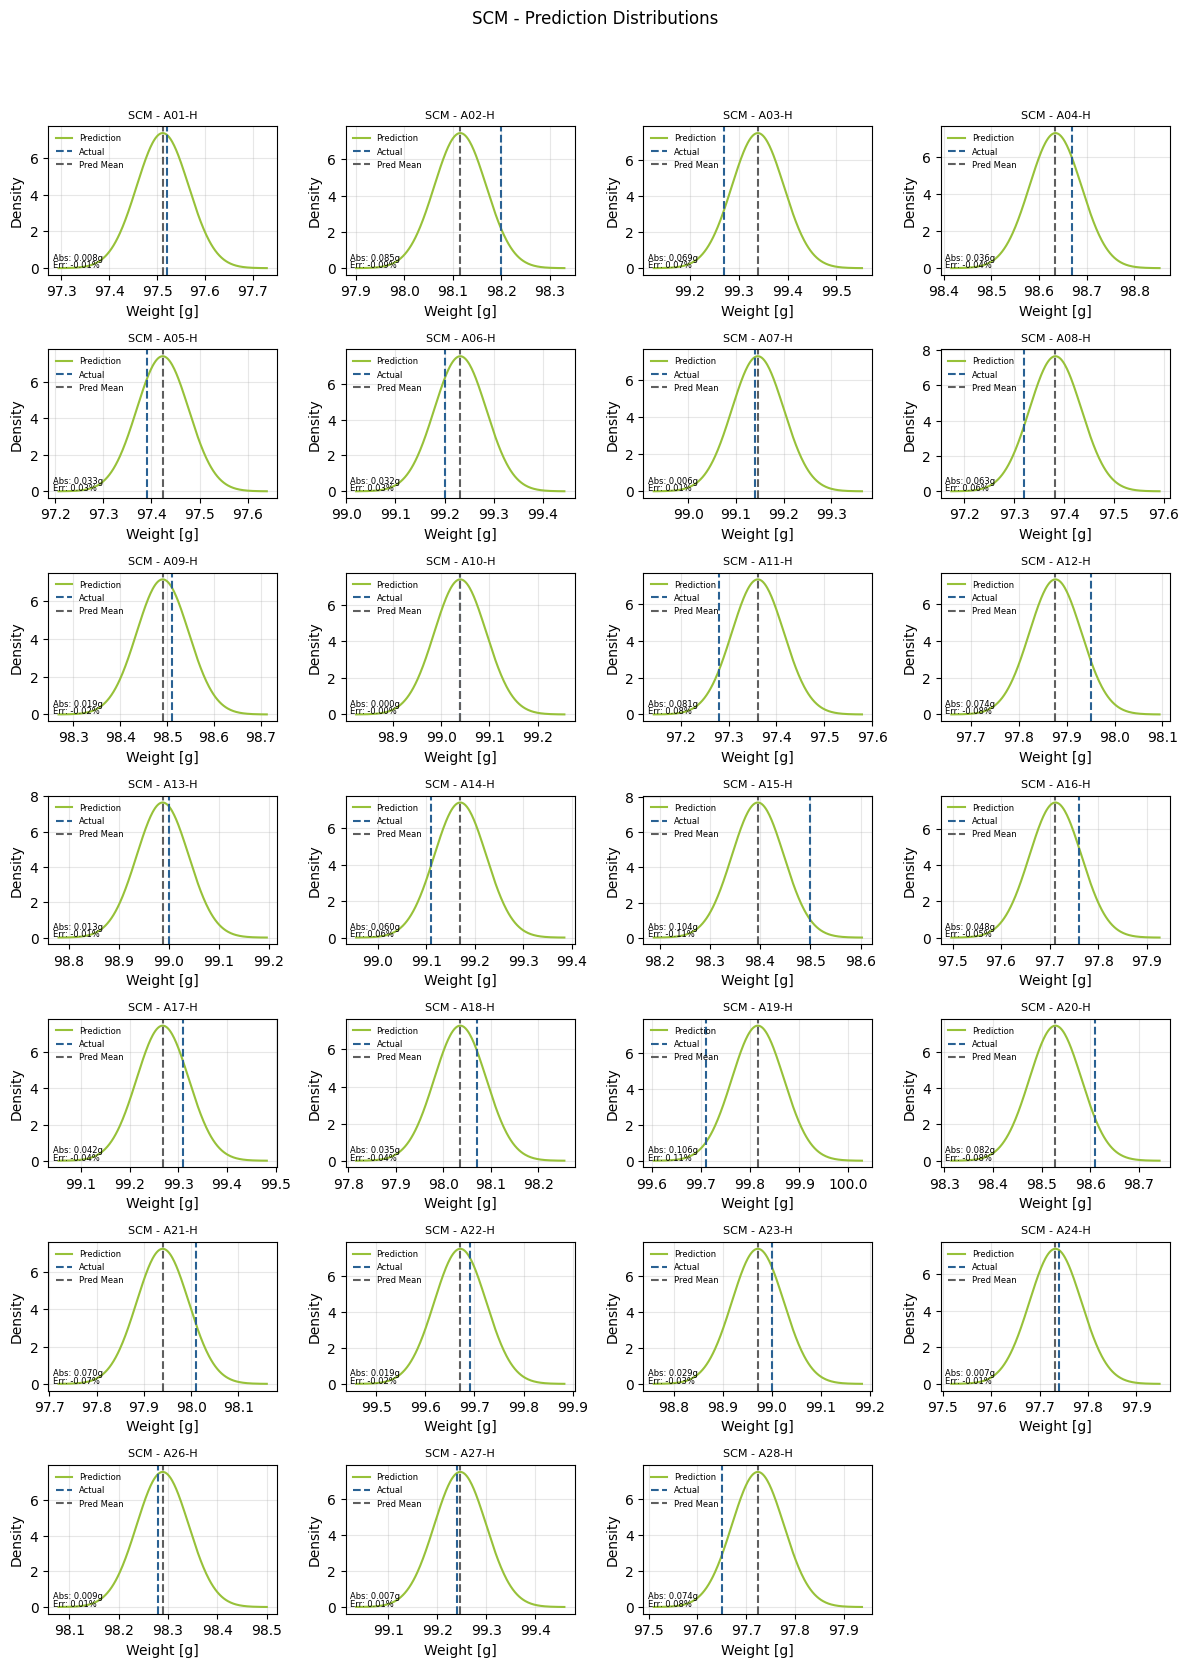

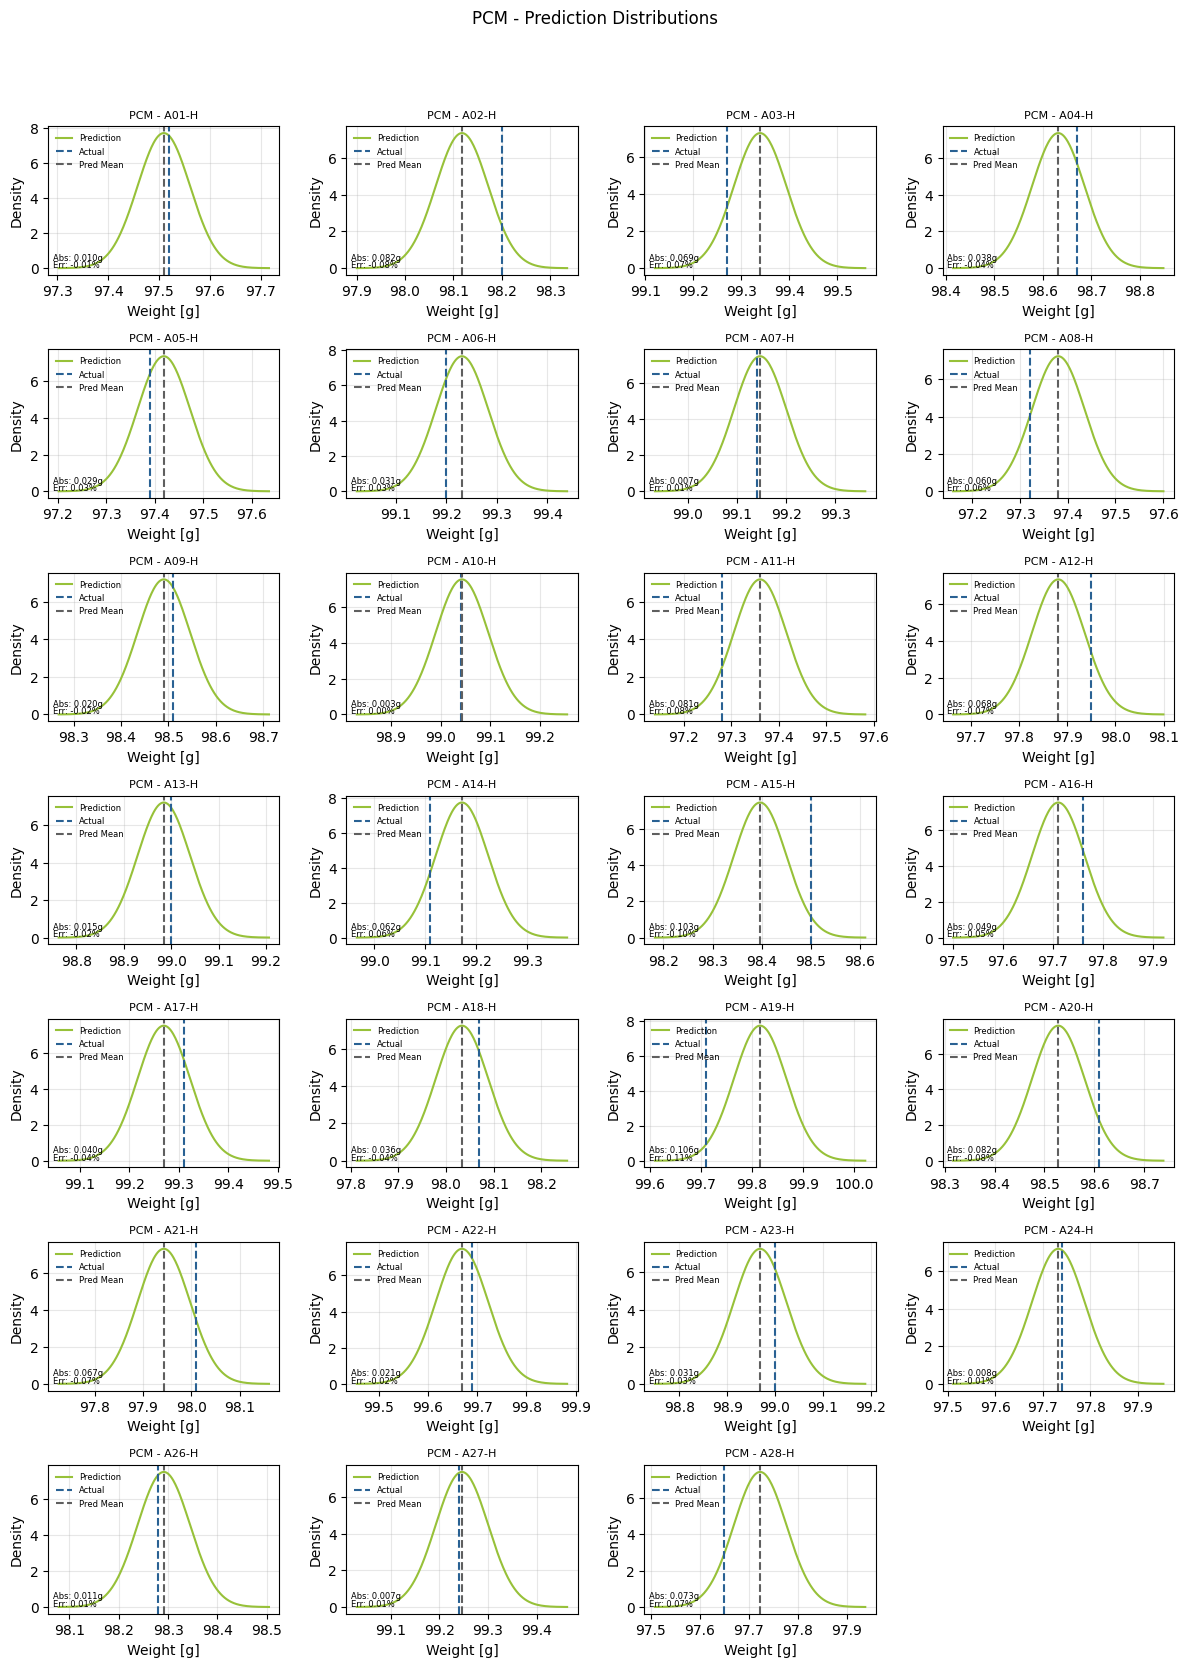

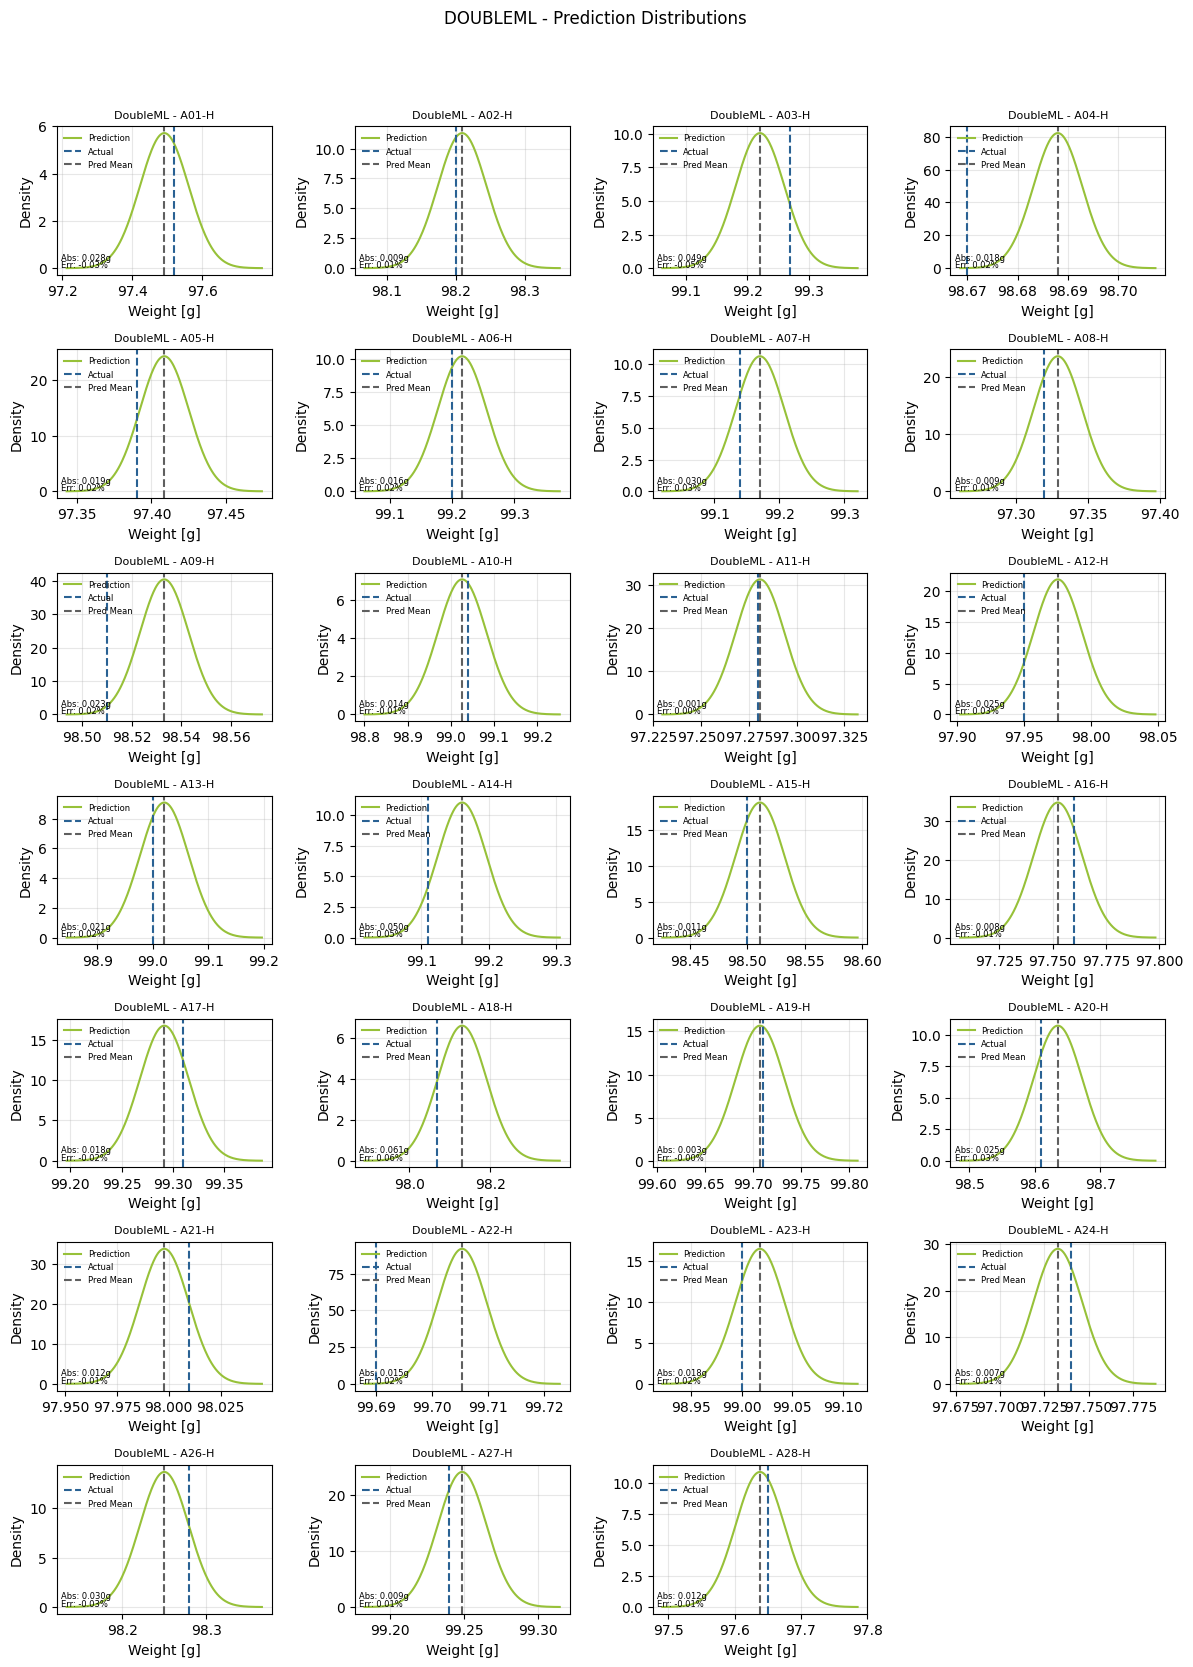

d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Thesis\Injection Molding\01_Dataset_Jul20_2023\Code\causality\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X 

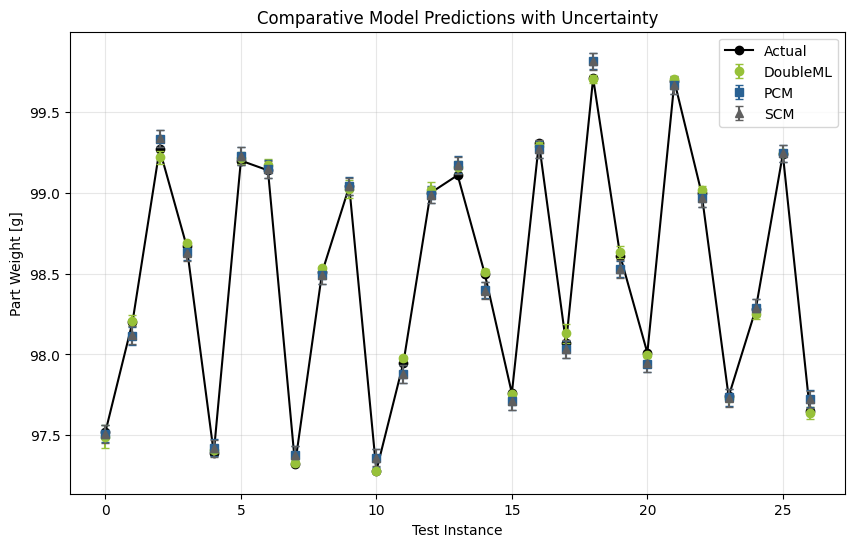

In [18]:
# Run all distribution plots with consistent sample selection
run_visualization_comparison(X_test, y_test, scm_preds_test, pcm_preds_test, doubleml_preds_test)

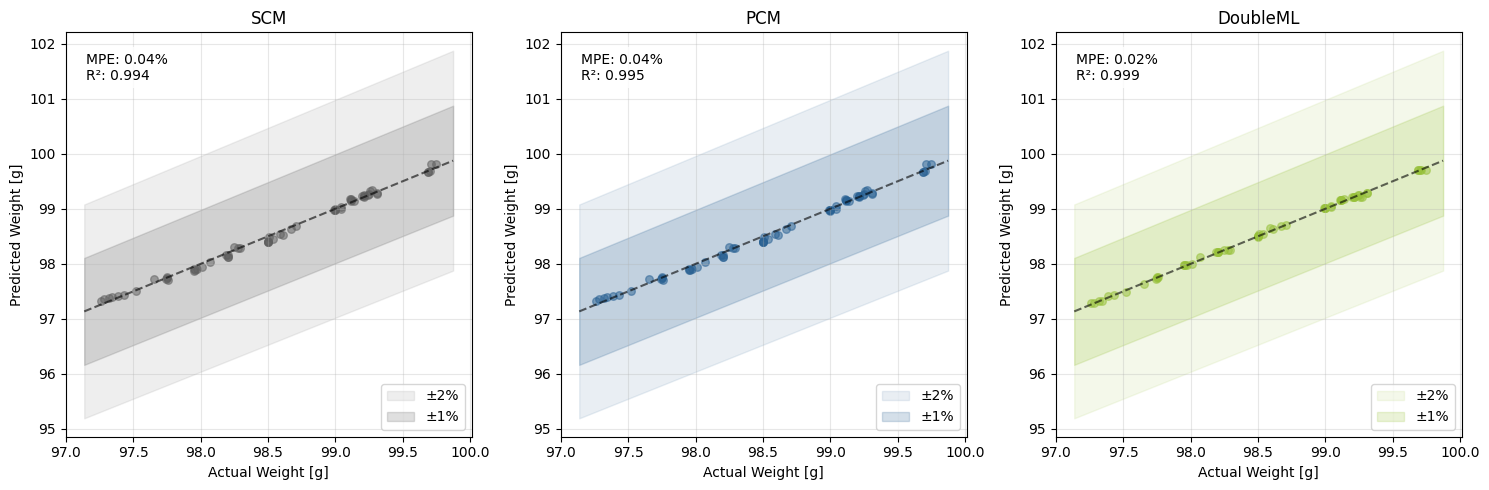

In [19]:
# Predicted vs. Actual Scatter Plots (±1–2% lines)
create_scatter_comparison(
    y_test.values,
    scm_preds_test['mean'],
    pcm_preds_test['mean'],
    doubleml_preds_test['mean']
)

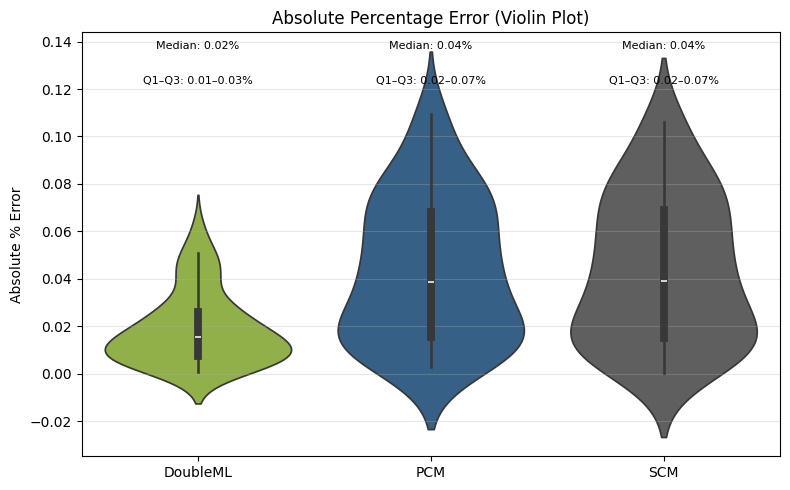

In [20]:
# Violin Plot of Absolute % Errors
create_violin_plot_errors(
    y_test.values,
    doubleml_preds_test['mean'],
    pcm_preds_test['mean'],
    scm_preds_test['mean']
)

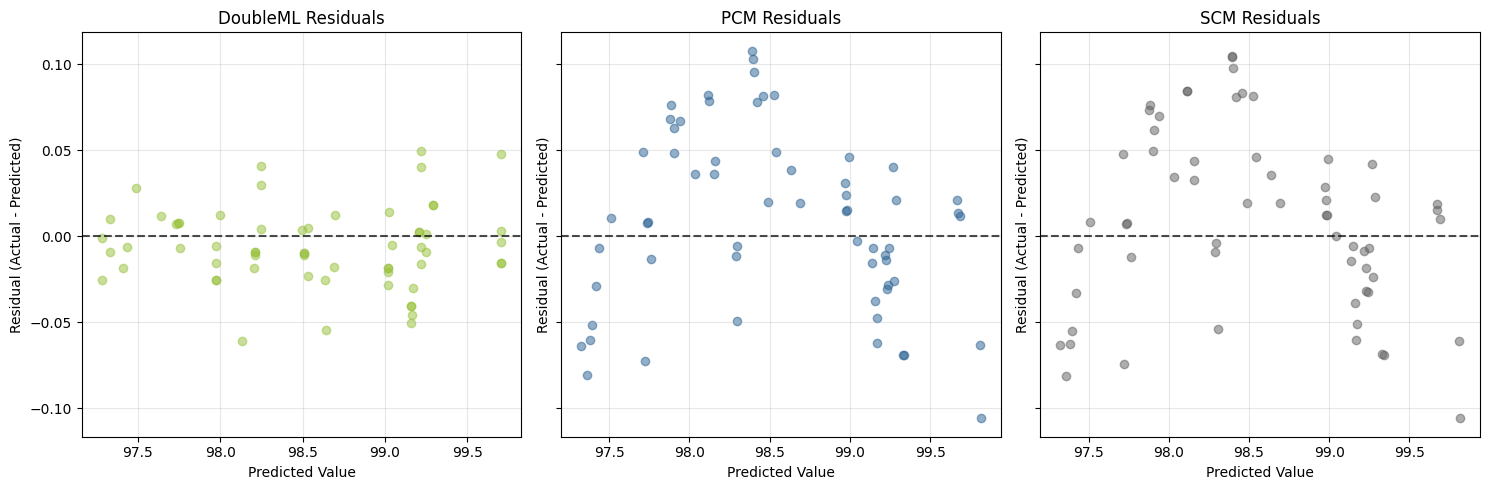

In [21]:
# Residual Plots
plot_residuals_side_by_side(
    y_test.values,
    doubleml_preds_test['mean'],
    pcm_preds_test['mean'],
    scm_preds_test['mean']
)

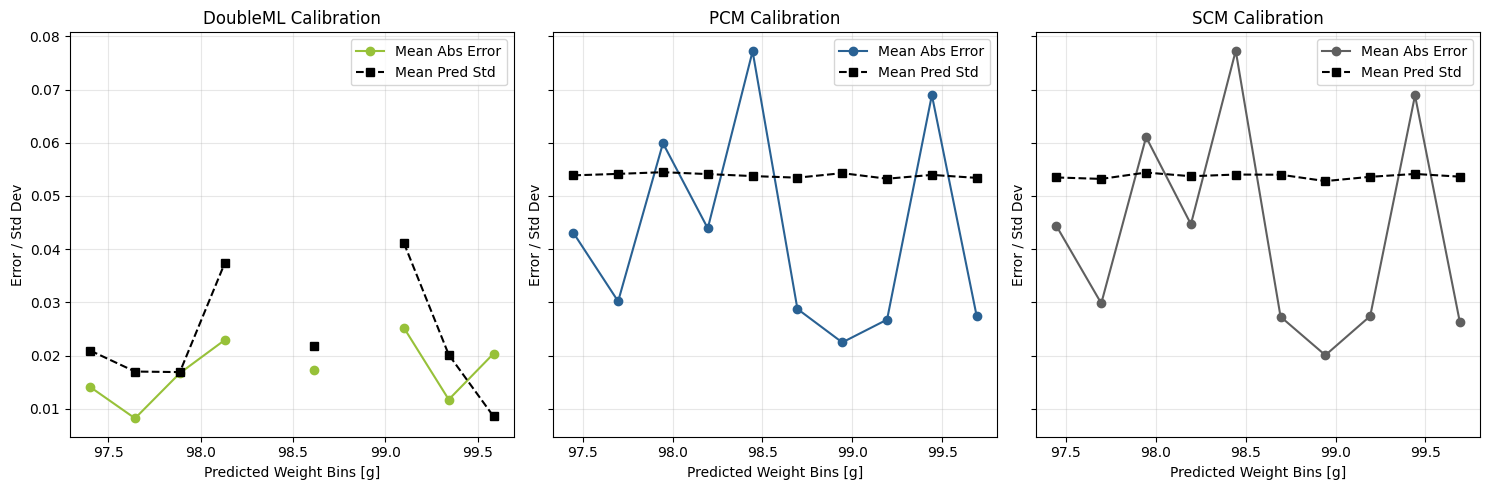

In [22]:
# Calibration Curves
plot_calibration_curves_side_by_side(
    y_true=y_test.values,
    doubleml_pred=doubleml_preds_test['mean'],
    pcm_pred=pcm_preds_test['mean'],
    scm_pred=scm_preds_test['mean'],
    doubleml_std=doubleml_preds_test['std'],
    pcm_std=pcm_preds_test['std'],
    scm_std=scm_preds_test['std'],
    num_bins=10
)


=== Temporal Error Analysis ===


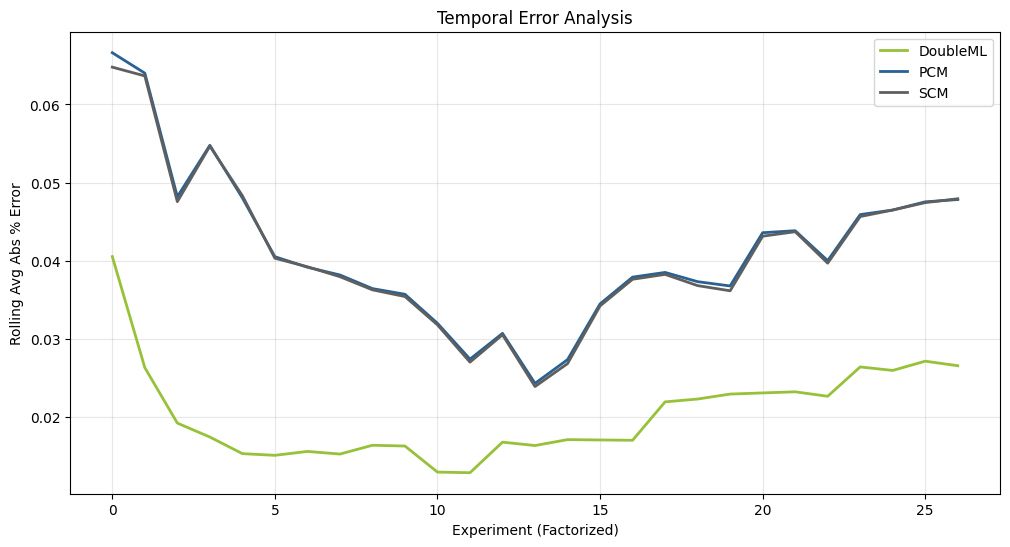

In [23]:
# Temporal Error Analysis
if "MET_ExperimentNumber" in X_test.columns:
    experiment_numbers, _ = pd.factorize(X_test["MET_ExperimentNumber"])
    
    def create_temporal_error_analysis(y_true, doubleml_pred, pcm_pred, scm_pred, experiment_numbers):
        plt.figure(figsize=(12,6))
        errors = {
            'DoubleML': np.abs((doubleml_pred - y_true) / y_true * 100),
            'PCM':      np.abs((pcm_pred - y_true) / y_true * 100),
            'SCM':      np.abs((scm_pred - y_true) / y_true * 100)
        }
        window = 10
        colors = [fapsgreen_hex, fapsblue_hex, fapsdarkgray_hex]
        df_nums = pd.DataFrame({'exp': experiment_numbers})
        for (model, err), color in zip(errors.items(), colors):
            df_nums['error'] = err
            mean_by_exp = df_nums.groupby('exp')['error'].mean().sort_index()
            rolling_mean = mean_by_exp.rolling(window=window, min_periods=1).mean()
            plt.plot(rolling_mean.index, rolling_mean.values, '-', label=model, color=color, linewidth=2)
        plt.xlabel('Experiment (Factorized)')
        plt.ylabel('Rolling Avg Abs % Error')
        plt.title('Temporal Error Analysis')
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()
    
    print("\n=== Temporal Error Analysis ===")
    create_temporal_error_analysis(
        y_true=y_test.values,
        doubleml_pred=doubleml_preds_test['mean'],
        pcm_pred=pcm_preds_test['mean'],
        scm_pred=scm_preds_test['mean'],
        experiment_numbers=experiment_numbers
    )

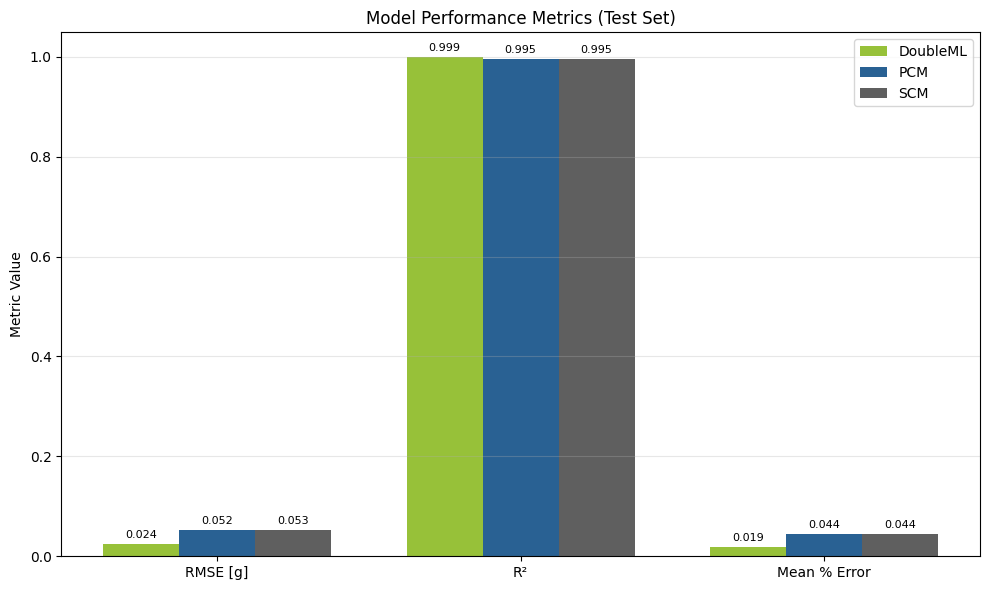

In [24]:
# Model Performance Comparison (Bar Chart)
create_metric_comparison(metrics_doubleml, metrics_pcm, metrics_scm)